In [1]:
import numpy as np
from numpy import random
from scipy.stats import dirichlet
from scipy.stats import bernoulli
from tqdm import tqdm
random.seed(10)

In [2]:
def topk(mat,k):
    e_vals,e_vecs = np.linalg.eig(mat)
    sorted_indices = np.argsort(np.absolute(e_vals) )
    return e_vals[sorted_indices[:-k-1:-1]],e_vecs[:,sorted_indices[:-k-1:-1]]



In [3]:
import numpy as np
from numpy import random
from scipy.stats import dirichlet
from scipy.stats import bernoulli
random.seed(10)
alpha = np.array([40, 40, 40, 40])
beta=np.array([40,40,40])
n_1=7 #number of the rows of \Pi_P
n_2=8000 #number of the rows of \Pi_d
Pi_p=np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1],[1,0,0,0],[0.3,0.4,0.3,0],[0.2,0.5,0.1,0.2]])
P=np.array([[0.5, 0.7, 0.2], [0.8,0.3,0.1], [0.2,0.6,0.4], [0.6,0.3,0.5]])

In [4]:
import numpy as np
from numpy import random
from scipy.stats import dirichlet
from scipy.stats import bernoulli
alpha = np.array([40, 40, 40, 40])
beta=np.array([40,40,40])
T2=10000
Pi_d_huge=random.multinomial(n=1, pvals=[0.35,0.4,0.25],size=n_2*T2)
#Pi_d_huge.size


In [5]:
def move(X):
    Y=np.copy(X)
    Y[4][0]=Y[4][4]
    Y[0][4]=Y[4][4]
    Y[4][4]=Y[0][0]
    return Y

kafang=np.zeros(T2)
for k in tqdm(range(T2)):
    EX_1_k=Pi_p@P@Pi_d_huge[k*n_2:(k+1)*n_2].T
 
    X_1_k=bernoulli.rvs(EX_1_k,size=(n_1,n_2))
    Sum_s_mean=X_1_k@X_1_k.T/n_2
    Sum_s_mean[4][0]=Sum_s_mean[4][4]
    Sum_s_mean[0][4]=Sum_s_mean[4][4]
    Sum_s_mean[4][4]=Sum_s_mean[0][0]
    
    #print(Sum_s_mean)
    vals,vecs = topk(Sum_s_mean,6)
    #print(vals)
    #for j in range(6):
        #if vecs[0,j]<0:
            #vecs[:,j]=-vecs[:,j]
    
    A0=np.array([vecs[:,j]/vals[j] for j in range(0,6)])
    A1=np.identity(7)-vecs[:,0:6]@vecs[:,0:6].T
    A=np.kron(A0,A1[0]-A1[4])
    Vec_X=np.zeros((n_2,49) )
    for q in range(n_2):
        Vec_X[q]=move((X_1_k[:,q][:,np.newaxis]@X_1_k[:,q][:,np.newaxis].T)).reshape(-1)
    Cov_X=(Vec_X-np.mean(Vec_X,axis=0) ).T@(Vec_X-np.mean(Vec_X,axis=0) )/(n_2-1) 
    #print(Cov_X)
    #print(A@Cov_X@A.T)
    #print(vals)
    kafang[k]=n_2*(vecs[0]-vecs[4])@np.linalg.pinv(A@Cov_X@A.T)@(vecs[0]-vecs[4]).T
    #print( n_2*(vecs[0]-vecs[4])@np.linalg.pinv(A@Cov_X@A.T)@(vecs[0]-vecs[4]).T )


    


        

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [11:02<00:00, 15.10it/s]


In [6]:
import sys
sys.path.insert(1,'C:/Users/hhz13/Downloads/ITE-1.1_code')
import ite
co=ite.cost.MDKL_HSCE()
estimate_kafang=np.zeros((10000,1))
for i in range(10000):
    estimate_kafang[i][0]=kafang[i]
print(estimate_kafang)

[[ 2.35996709]
 [10.95422285]
 [ 5.21989846]
 ...
 [ 2.54405287]
 [ 5.81833968]
 [ 6.49028162]]


In [7]:
from numpy import random
kafang_groundtruth=random.chisquare(df=6, size=100000)
#print(kafang_groundtruth)
kafang_groundtruth_vector=np.zeros((100000,1))
for j in range(100000):
    kafang_groundtruth_vector[j][0]=kafang_groundtruth[j]

In [8]:
co.estimation(estimate_kafang,kafang_groundtruth_vector)

0.03965818909041108

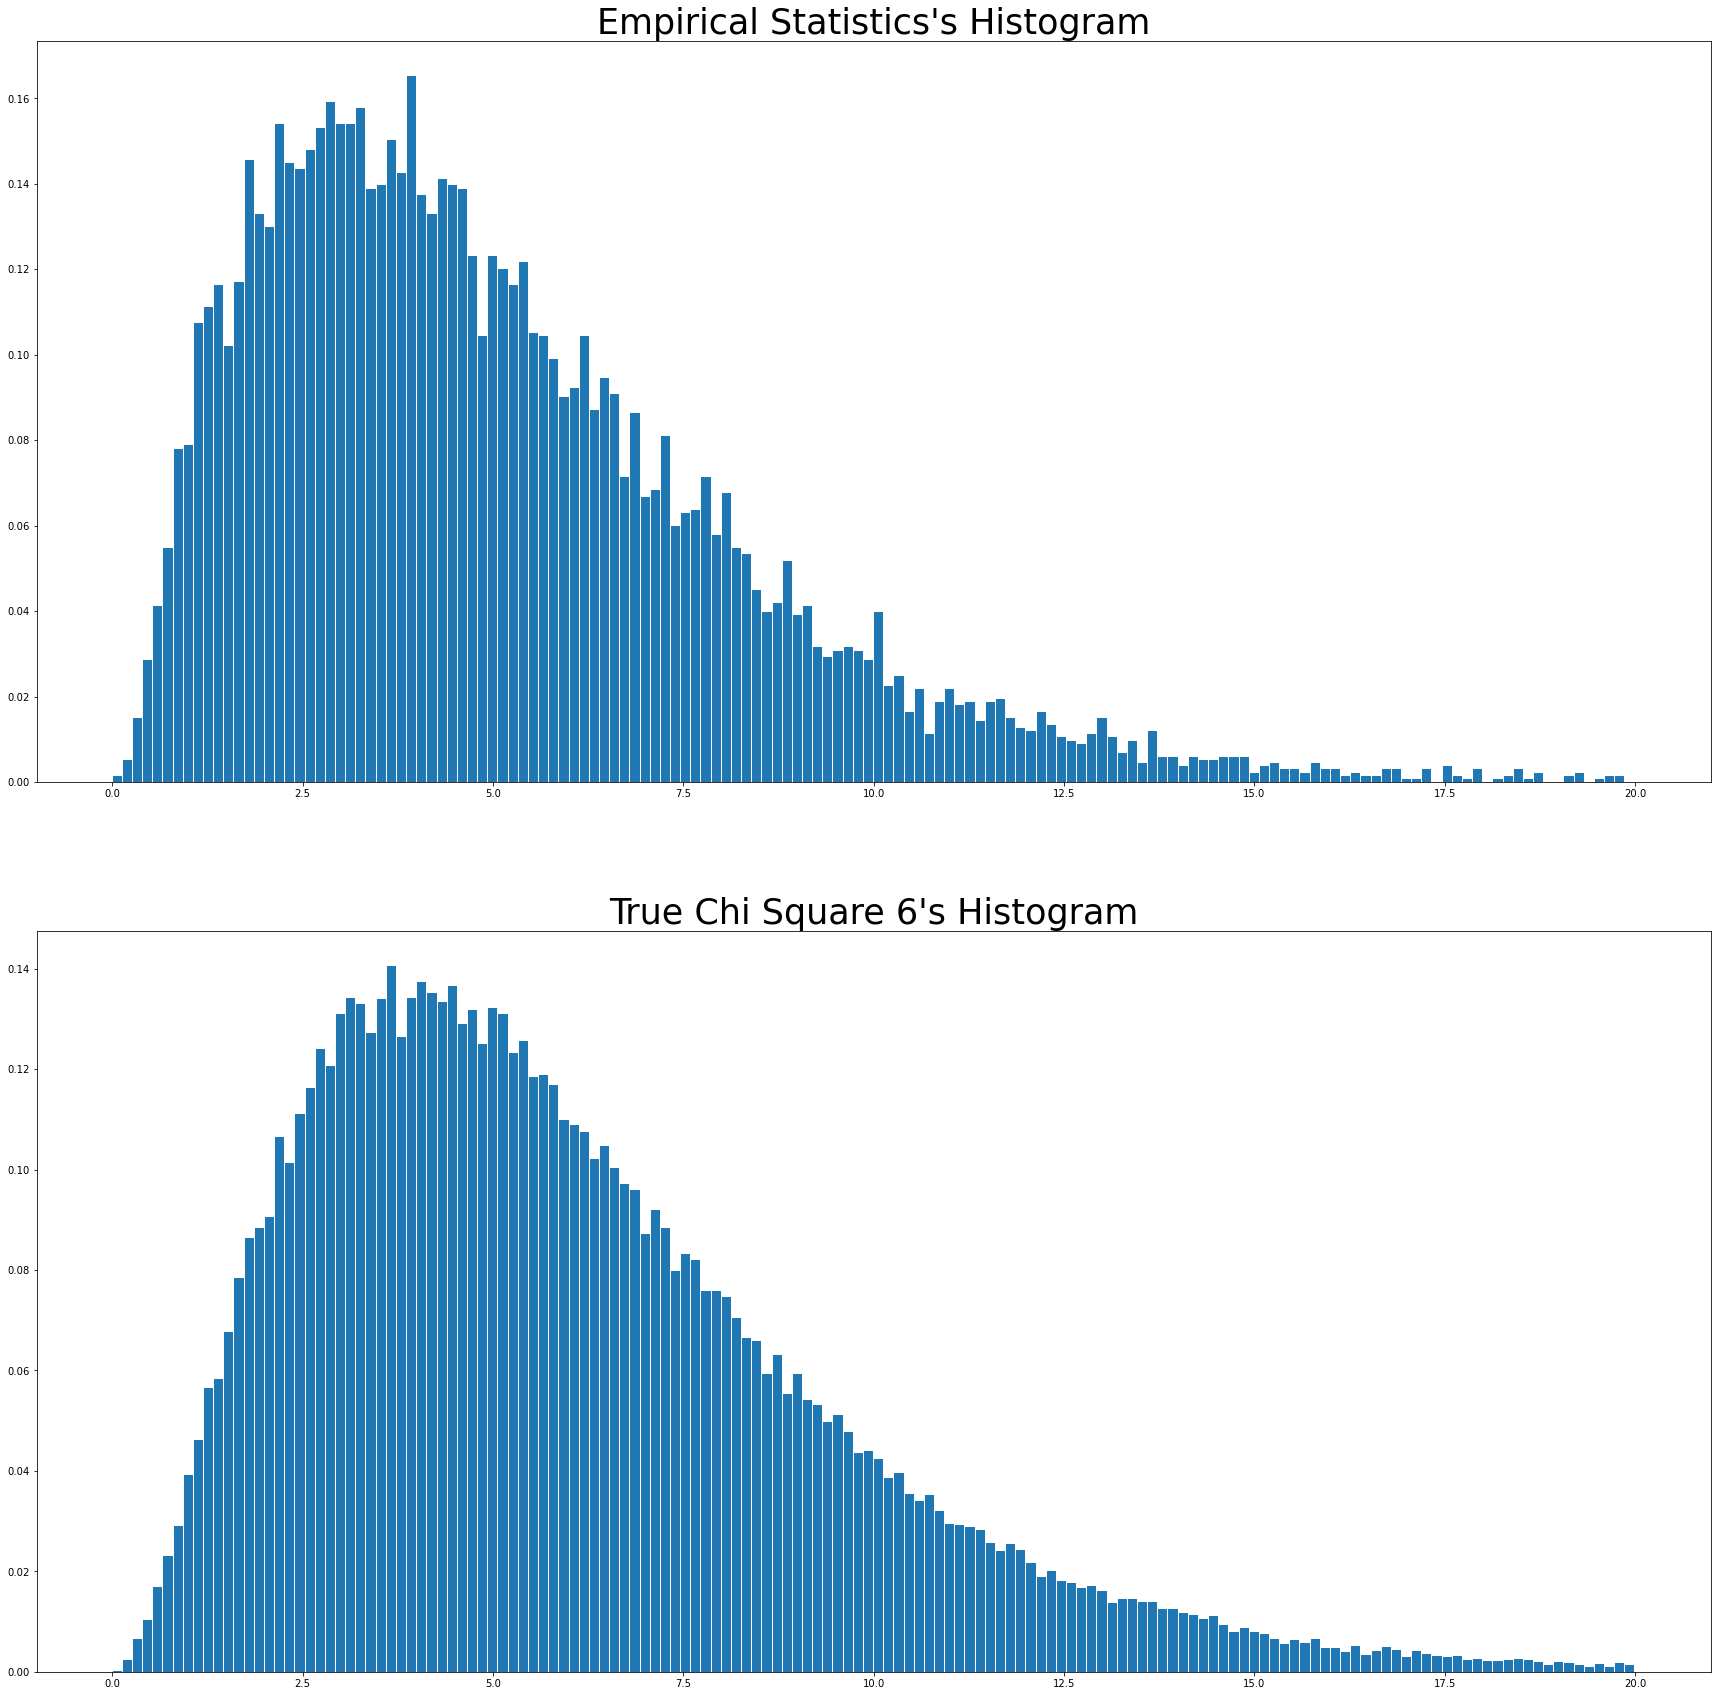

In [10]:
import matplotlib.pyplot as plt
fig,axs=plt.subplots(2,1,figsize=(30,30))
axs[0].hist(estimate_kafang[:,0], range=(0,20),bins=150, rwidth=0.9, density=True)
axs[0].set_title("Empirical Statistics's Histogram",fontsize=35)
axs[1].hist(kafang_groundtruth, range=(0,20),bins=150, rwidth=0.9, density=True)
axs[1].set_title("True Chi Square 6's Histogram",fontsize=35)
plt.savefig('C:\\Users\\hhz13\\Downloads\\Annuals_Experiment.eps', format='eps', dpi=1000)